# Question 1

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [28]:
#Fama french factors
ff_df = pd.read_csv('../data/ff_factors_and_mom.csv', sep=',')
ff_df['date'] = pd.to_datetime(ff_df['date'], format='%d/%m/%Y', dayfirst=True)
ff_df.set_index('date', inplace=True)

In [29]:
# industry portfolio
ind_df = pd.read_csv('../data/49_industry_portfolios.csv', sep=',')

ind_df['date'] = pd.to_datetime(ind_df['date'], format='%d/%m/%Y')
ind_df.set_index('date', inplace=True)

In [30]:
ind_ret = ind_df / 100.0

In [31]:
#Rolling 10y annualized (*12) mean returns
rolling_mean_10y = ff_df['mom'].rolling(window=120).mean() * 12

In [32]:
def calculate_stats(series, name="Series"):
    ann_mean = series.mean() * 12
    #ann_std = series.std() * np.sqrt(12)
    t_stat = series.mean() / (series.std() / np.sqrt(len(series)))
    return ann_mean, t_stat

In [33]:
mean_full, t_full = calculate_stats(ff_df['mom'], "Full History")

In [34]:
mean_full, t_full

(0.07475979381443301, 4.520011040876052)

In [35]:

last_date = ff_df.index[-1]
start_20y = last_date - pd.DateOffset(years=20)
mom_20y = ff_df[ff_df.index > start_20y]
mean_20y, t_20y = calculate_stats(mom_20y, "Last 20Y")

In [36]:
mean_20y

rf       0.013454
mktrf    0.094088
smb      0.003396
hml     -0.004013
mom      0.004178
dtype: float64

In [37]:
t_20y

rf       12.279393
mktrf     2.739705
smb       0.177951
hml      -0.163763
mom       0.122725
dtype: float64

In [38]:
start_10y = last_date - pd.DateOffset(years=10)
mom_10y = ff_df[ff_df.index > start_10y]
mean_10y, t_10y = calculate_stats(mom_10y, "Last 10Y")

In [39]:
mean_10y

rf       0.011574
mktrf    0.112116
smb     -0.013448
hml     -0.016334
mom      0.009660
dtype: float64

In [40]:
t_10y

rf       8.322089
mktrf    2.265468
smb     -0.450509
hml     -0.403593
mom      0.225216
dtype: float64

## Construct Industry Momentum strategy

for robustness check

In [41]:
rolling_11m_cumulative = (1 + ind_ret).rolling(11).apply(np.prod, raw=True) - 1
past_performance = rolling_11m_cumulative.shift(2)
past_performance.sample(n=5)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
date,,,,,,,,,,,,,,,,,,,,,
1976-12-31,0.018947,0.076312,0.031629,0.067287,0.137936,0.242712,0.005161,0.213008,0.017614,0.167591,...,0.079374,0.207093,0.178946,0.043359,-0.064068,0.182039,0.227215,0.445263,0.247209,0.150555
1952-08-29,-0.005785,0.059251,NaN,-0.085605,0.061866,0.173965,-0.057216,0.095581,0.004451,0.019929,...,0.060287,0.226210,0.057986,0.060549,0.184580,0.311725,0.143895,0.233996,0.242910,-0.047345
2017-02-28,0.181699,0.124230,0.002722,0.059064,0.113238,0.161462,0.297120,0.098819,0.066636,-0.099953,...,0.337852,0.337625,0.176353,0.075731,0.103220,0.366989,0.263425,0.081290,0.370747,0.197113
1960-08-31,0.233123,0.161037,NaN,-0.138281,0.164043,0.657508,0.015893,0.302374,0.213750,-0.021860,...,0.058458,-0.137331,0.109987,0.098359,0.063999,0.011642,-0.028635,-0.127040,-0.120241,0.159677
1997-09-30,0.317882,0.432589,0.896507,0.354709,0.525464,0.286838,0.192240,0.312888,0.498589,0.222702,...,0.556850,0.370020,0.185326,0.314594,0.135526,0.632491,0.590499,0.193892,0.675488,0.209962


In [42]:
ind_mom_returns = []
valid_dates = []

# Loop through dates where we have enough history
for date in ind_ret.index:
    if date not in past_performance.index:
        continue

    past_rets = past_performance.loc[date]
    curr_rets = ind_ret.loc[date]

    if past_rets.isna().all():
        continue

    # Rank industries
    sorted_inds = past_rets.sort_values()
    # Remove nulls
    sorted_inds = sorted_inds.dropna()

    if len(sorted_inds) < 10:
        continue  # Need at least 10 industries to do top 5 / bottom 5

    # Long Top 5, Short Bottom 5
    bottom_5 = sorted_inds.index[:5]
    top_5 = sorted_inds.index[-5:]

    # Strategy Return = Average(Winners) - Average(Losers)
    ret = curr_rets[top_5].mean() - curr_rets[bottom_5].mean()

    ind_mom_returns.append(ret)
    valid_dates.append(date)

In [43]:
ind_mom_series = pd.Series(ind_mom_returns, index=valid_dates)
ind_mom_series.sample(n=5)

1989-09-29    0.00520
2022-10-31    0.04134
1998-10-30   -0.00262
1970-02-27   -0.01526
2014-03-31   -0.01602
dtype: float64

In [44]:
ind_mom_rolling = ind_mom_series.rolling(window=120).mean() * 12
ind_mom_rolling.sample(n=5)

2002-01-31    0.150618
1968-11-29    0.170324
1989-06-30    0.066210
1928-06-30         NaN
1928-09-29         NaN
dtype: float64

In [45]:
correlation = ff_df['mom'].corr(ind_mom_series)
correlation

0.7456660589313867

## Visuals

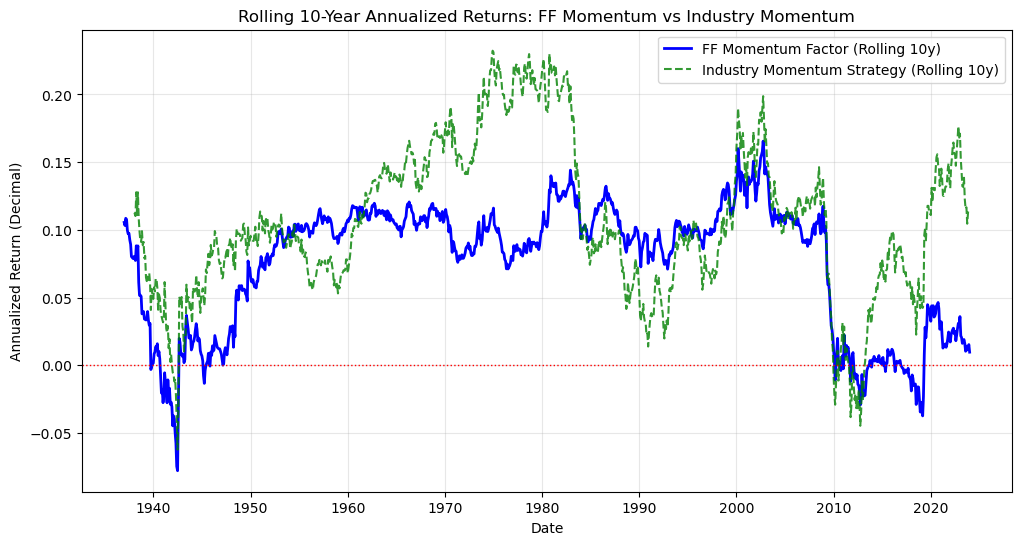

In [46]:
plt.figure(figsize=(12, 6))

# FF Momentum
plt.plot(rolling_mean_10y.index, rolling_mean_10y,
         label='FF Momentum Factor (Rolling 10y)', color='blue', linewidth=2)
#Industry momentum
plt.plot(ind_mom_rolling.index, ind_mom_rolling,
         label='Industry Momentum Strategy (Rolling 10y)', color='green', linestyle='--', alpha=0.8)

plt.axhline(0, color='red', linestyle=':', linewidth=1)

plt.title('Rolling 10-Year Annualized Returns: FF Momentum vs Industry Momentum')
plt.ylabel('Annualized Return (Decimal)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


This graph illustrates the rolling 10-year annualized returns of the Fama-French Momentum factor and an Industry Momentum strategy. It highlights a distinct structural break: while momentum consistently delivered positive premiums (often >5%) for most of the 20th century, returns for both strategies have collapsed to approximately zero over the last two decades, suggesting a potential regime change in market efficiency. There is clearly a post abd pre momentum crash

In [47]:
mom_series = ff_df['mom']
mean_mom = mom_series.mean()
std_mom = mom_series.std()
t_stat, p_value = stats.ttest_1samp(mom_series, 0)


annual_std = std_mom * np.sqrt(12)
sharpe_ratio = mean_full / annual_std

print("Full history stats")
print(f"Annualized Mean: {mean_full:.2%}")
print(f"Annualized Std Dev: {annual_std:.2%}")
print(f"T-statistic: {t_full:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}\n")

Full history stats
Annualized Mean: 7.48%
Annualized Std Dev: 16.29%
T-statistic: 4.5200
P-value: 6.8152e-06
Sharpe Ratio: 0.4589



In [48]:
# 4. 10y by 10y
ff_df['decade'] = (ff_df.index.year // 10) * 10
decade_stats = ff_df.groupby('decade')['mom'].agg(['mean', 'std', 'count'])
decade_stats['annual_mean'] = decade_stats['mean'] * 12
decade_stats['t_stat'] = (
    decade_stats['mean'] / (decade_stats['std'] / np.sqrt(decade_stats['count'])))

print(decade_stats[['annual_mean', 't_stat']])

# 5. Last 10 Years Performance (Rolling 120 months)
last_decade_mom = mom_series.iloc[-120:]
last_decade_mean = last_decade_mom.mean() * 12
last_decade_tstat, last_decade_p = stats.ttest_1samp(last_decade_mom, 0)
print('Last 10y stats')
print(f"Annualized Mean: {last_decade_mean:.2%}")
print(f"T-statistic: {last_decade_tstat:.4f}")
print(f"P-value: {last_decade_p:.4f}")

        annual_mean    t_stat
decade                       
1920       0.240600  4.559609
1930       0.001640  0.015788
1940       0.065930  2.215237
1950       0.107360  4.335235
1960       0.110930  3.742224
1970       0.098790  2.389921
1980       0.091900  2.348188
1990       0.136080  3.860548
2000       0.010850  0.144856
2010       0.032560  0.945502
2020      -0.007625 -0.096070
Last 10y stats
Annualized Mean: 0.97%
T-statistic: 0.2247
P-value: 0.8226


### 1. **Declining Performance Over Time**
- **Full history annualized mean**: 7.48% (t-stat: 4.52, highly significant)
- **Last 20 years**: 0.42% (t-stat: 0.12, not significant)
- **Last 10 years**: 0.97% (t-stat: 0.23, not significant)

The momentum premium has essentially disappeared in recent decades, with no statistical significance.

Recent decades show weaker momentum performance compared to earlier periods, suggesting a structural shift in markets.

The industry momentum strategy (correlation: **0.83** with FF momentum) shows similar patterns, confirming this isn't just a data artifact.

## Possible Explanations:
- Crowding: Momentum strategies are now widely known and implemented, reducing excess returns
- Market efficiency: Increased information flow and algorithmic trading may have arbitraged away the premium
- Regime change: Market structure changes post-2008 financial crisis

Without strong evidence of recovery, momentum returns over the next decade are most likely to remain approximately zero, continuing the recent trend rather than reverting to historical means.

# Question 2

## Correlation between the Return on Momentum and Value Portfolios

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We first clean the data

In [50]:
df_factors = pd.read_csv("../data/ff_factors_and_mom.csv")

In [51]:
df_factors["date"] = pd.to_datetime(df_factors["date"], dayfirst=True)
df_factors=df_factors.sort_values("date")
df_factors = df_factors.set_index("date")
df_factors.head()

,rf,mktrf,smb,hml,mom
date,,,,,
1927-01-31,0.0025,-0.0006,-0.0037,0.0454,0.0036
1927-02-28,0.0026,0.0418,0.0004,0.0294,-0.0214
1927-03-31,0.0030,0.0013,-0.0165,-0.0261,0.0361
1927-04-30,0.0025,0.0046,0.0030,0.0081,0.0430
1927-05-31,0.0030,0.0544,0.0153,0.0473,0.0300


We extract the momentum and value columns from our dataframe for futher analysis

In [52]:
df_mom_hml = df_factors[["mom", "hml"]].dropna()
df_mom_hml.head()

,mom,hml
date,,
1927-01-31,0.0036,0.0454
1927-02-28,-0.0214,0.0294
1927-03-31,0.0361,-0.0261
1927-04-30,0.0430,0.0081
1927-05-31,0.0300,0.0473


In [53]:
momentum = df_mom_hml["mom"]
value = df_mom_hml["hml"]

The summary statistics of the momentum and value portfolios are shown below

In [54]:
print("Momentum portfolio (MOM) summary statistics:")
print(momentum.describe())

print("\nValue portfolio (HML) summary statistics:")
print(value.describe())

Momentum portfolio (MOM) summary statistics:
count    1164.000000
mean        0.006230
std         0.047024
min        -0.520500
25%        -0.009525
50%         0.008050
75%         0.029525
max         0.182000
Name: mom, dtype: float64

Value portfolio (HML) summary statistics:
count    1164.000000
mean        0.003483
std         0.035754
min        -0.138700
25%        -0.014025
50%         0.001300
75%         0.017525
max         0.356100
Name: hml, dtype: float64


We compute the correlation between momemtum and value portfolios by taking the sample with all available data we have. 

In [55]:
corr_full_sample = df_mom_hml["mom"].corr(df_mom_hml["hml"])

print("The correlation between MOM and HML portfolios, taken full samples, is ", 
      round(corr_full_sample,4))


The correlation between MOM and HML portfolios, taken full samples, is  -0.4057


The result shows that the correlaiton is negative. To show if this pattern persists in other samples, we limit the scope of data to the most recent 10 years and recompute the correlation

In [56]:
end_date_10y = df_mom_hml.index.max()
start_date_10y = end_date_10y - pd.DateOffset(years=10)
df_10y = df_mom_hml.loc[start_date_10y:end_date_10y]

corr_10y = df_10y["mom"].corr(df_10y["hml"])

print("The correlation between MOM and HML portfolios in the most recent 10 years is ", 
      round(corr_10y,4))

The correlation between MOM and HML portfolios in the most recent 10 years is  -0.3004


We then apply a 24-month rolling window to see if the negative correlation exists across all time.

# Empirical Question 3